# Transfer Learning Tutorial : Unsupervised Instance-Based Approaches

In this tutorial, we are going to apply instance-based approaches to perform transfer learning.


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from utils import show_gaussian, gaussian

In [2]:
# import importlib
# import utils
# importlib.reload(utils)
# from utils import show_gaussian, gaussian

# Exercise 1 : Gaussians 1D

## 1. Weighted Regression

In this exercise, we consider two domains defined on $\mathbb{R}$ : the source domain $P_S(X, Y)$ and the target domain $P_T(X, Y)$ where:

$$P_S(X) = \mathcal{N}(-1, 1)$$

$$P_T(X) = \mathcal{N}(1, 1)$$

$$P_S(Y|X=x) = P_T(Y|X=x) = \mathcal{N}(|x|, 0.5)$$

We remind the definition of the gaussian density function of mean $\mu$ and standard deviation $\sigma$:

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-(x-\mu)^2}{2 \sigma^2} \right)$$

We consider the scenario where the learner has access to a source **labeled** sample `(Xs, ys)` of size $m=30$ drawn according to $P_S(X, Y)$ and a target **unlabeled** sample `Xt` of size $n=30$ drawn according to $P_T(X)$.

**NB** : For the tutorial purpose, we sample also the associated labels `yt` which are not available at training time but will be used to evaluate the models on the target domain.

In [3]:
def label_func(x, noise=0.1):
    return np.abs(x.ravel()) + noise * np.random.randn(len(x))

np.random.seed(0)
Xs = np.random.randn(30, 1) * 1. - 1.
Xt = np.random.randn(30, 1) * 1. + 1.
ys = label_func(Xs, 0.5)
yt = label_func(Xt, 0.5)

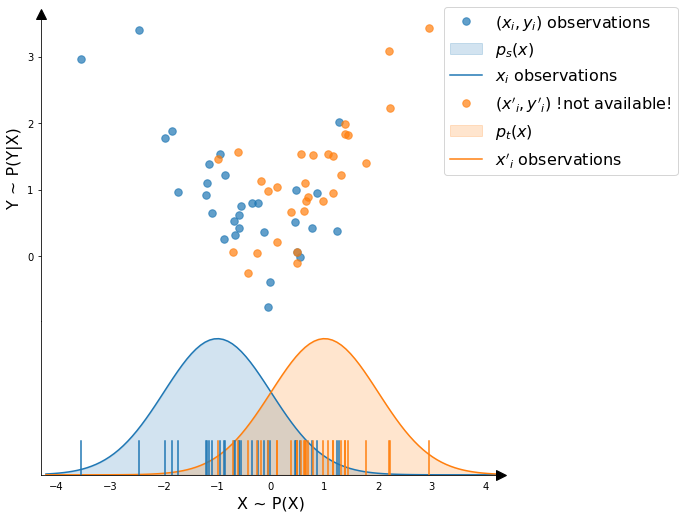

In [4]:
show_gaussian(Xs, Xt, ys, yt)

### Question 1.1 :

Use `scikit-klearn` to fit a linear model on the source labeled data `(Xs, ys)` and show the model predictions on the plot

In [5]:
from sklearn.linear_model import LinearRegression

model_source_only = LinearRegression()
model_source_only.fit(Xs, ys);

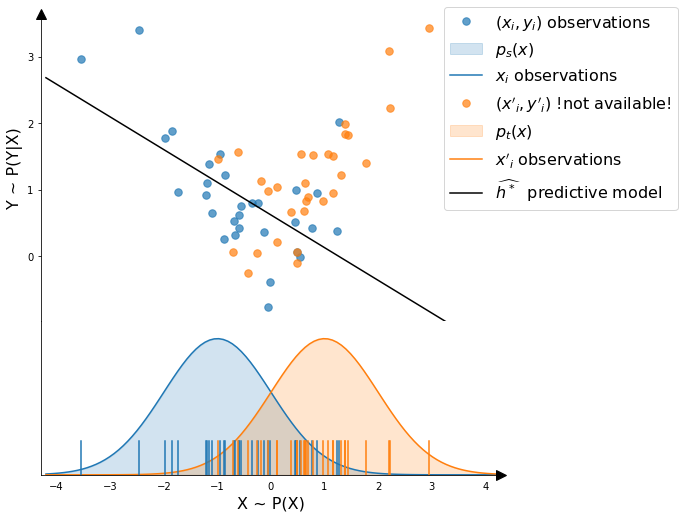

In [6]:
show_gaussian(Xs, Xt, ys, yt, model=model_source_only)

### Question 1.2 :

Compute the source and target empirical average squared errors : 

$$\underset{(x, y) \sim \widehat{P_S}(X, Y)}{\mathbb{E}}[(h(x)-y)^2]$$

$$\underset{(x, y) \sim \widehat{P_T}(X, Y)}{\mathbb{E}}[(h(x)-y)^2]$$

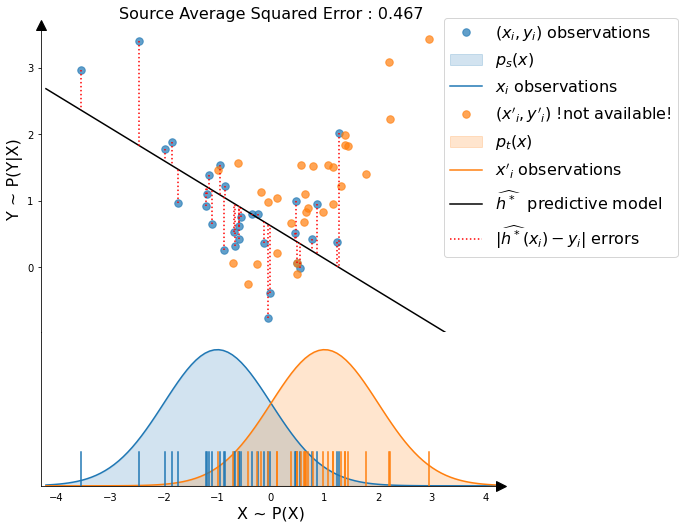

In [7]:
show_gaussian(Xs, Xt, ys, yt, model=model_source_only, show_error_src=True)

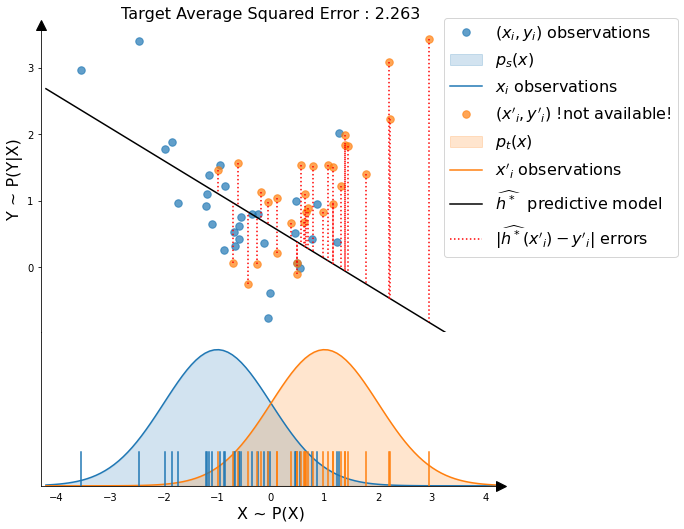

In [8]:
show_gaussian(Xs, Xt, ys, yt, model=model_source_only, show_error_tgt=True)

In [9]:
yps = model_source_only.predict(Xs)
err_src = np.mean(np.square(yps - ys))

ypt = model_source_only.predict(Xt)
err_tgt = np.mean(np.square(ypt - yt))

print("Source average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

Source average squared error : 0.4669
Target average squared error : 2.2630


What do you observe ?

### Question 1.3 :

Assuming that the model error $\epsilon$ is a centered gaussian ($Y = X \beta + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma)$), compute the pvalue of the F-test that the source and target computed errors are drawn from the same law $\epsilon$.

For a risk $\alpha = 0.01$, can we reject the hypothesis that $\epsilon_s \sim \epsilon_t$ ?

In [10]:
F = err_src / err_tgt
scipy.stats.f.cdf(F, len(ys)-1, len(yt)-1)

2.879039874860376e-05

We now want to reweight the source risk to correct the shift between domains:

### Question 1.4 :

Considering the **covariate shift** assumption:
$$ P_S(Y|X=x) = P_T(Y|X=x) $$

We can show that the traget risk is equal to the reweighted source risk:

\begin{equation}
\label{reweighted-risk}
\underset{(x, y) \sim P_T(X, Y)}{\mathbb{E}}[(h(x)-y)^2] = \underset{(x, y) \sim P_S(X, Y)}{\mathbb{E}}[w(x) (h(x)-y)^2] \quad \quad (1)
\end{equation}

With $w(x)$ the density ratio defined as:

$$w(x) = \frac{p_t(x)}{p_s(x)}$$

Obviously, we need the support of $p_t(x)$ to be included in the support of $p_s(x)$ to define $w(x)$, i.e. $\text{supp}(p_t(x)) \subset \text{supp}(p_s(x))$. This is generally implicitely assumed when considering instance-based transfer learning.

**Proof**:

\begin{equation*}
\begin{split}
\underset{(x, y) \sim P_T(X, Y)}{\mathbb{E}} [(h(x) - y)^2] & = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} p_t(x, y) \, (h(x) - y)^2 dx dy \\
& = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} p_t(y|x) p_t(x) \, (h(x) - y)^2 dx dy \\
& = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} p_s(y|x) p_t(x) \, (h(x) - y)^2 dx dy \quad \quad \textbf{Covariate-Shift}\\
& = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} p_s(y|x) \frac{p_t(x)}{p_s(x)} p_s(x) \, (h(x) - y)^2 dx dy \\
& = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} w(x) p_s(y|x) p_s(x) \, (h(x) - y)^2 dx dy \\
& = \int_{(x, y) \in \mathcal{X} \times \mathcal{Y}} w(x) p_s(x, y) \, (h(x) - y)^2 dx dy \\
& = \underset{(x, y) \sim P_S(X, Y)}{\mathbb{E}} [w(x) (h(x) - y)^2 ]
\end{split}
\end{equation*}

### Question 1.5

If the distribution $p_t(x)$ and $p_s(x)$ are known (which is generally not the case) we can compute the density ratio exactly.

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-(x-\mu)^2}{2 \sigma^2} \right)$$

In our case we have:

\begin{equation*}
\begin{split}
w(x) & = p_t(x) / p_s(x) \\
 & = \left. \exp \left( \frac{-(x-\mu_t)^2}{2 \sigma_t^2} \right) \middle/ \exp \left( \frac{-(x-\mu_s)^2}{2 \sigma_s^2} \right) \right. \\
 & = \exp \left( \frac{-(x-1)^2}{2} + \frac{(x+1)^2}{2} \right) \\
 & = \exp \left( 2 x \right) \\
\end{split}
\end{equation*}

Now that we have expressed the density ratio $w(x)$ as a function of $x$, we write a python function for it. Then, we plot a comparison of the empirical source distribution with its reweighted counterpart.

In [11]:
def density_ratio(x):
    return np.exp(2 * x.ravel())

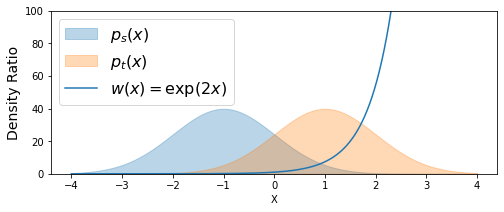

In [12]:
lin = np.linspace(-4, 4, 1000)
weights = density_ratio(lin)

plt.figure(figsize=(8, 3))
plt.fill_between(lin, gaussian(lin, mu=-1)*100., label=r"$p_s(x)$", alpha=0.3, edgecolor="C0")
plt.fill_between(lin, gaussian(lin, mu=1)*100., label=r"$p_t(x)$", alpha=0.3, edgecolor="C1")
plt.plot(lin, weights, c="C0", label=r"$w(x) = \exp(2 x)$")
plt.xlabel("X"); plt.ylabel("Density Ratio", fontsize=14); plt.legend(fontsize=16); plt.ylim(0, 100); plt.show()

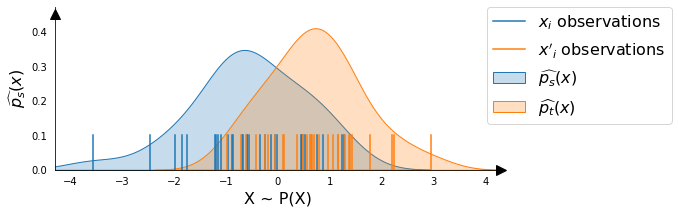

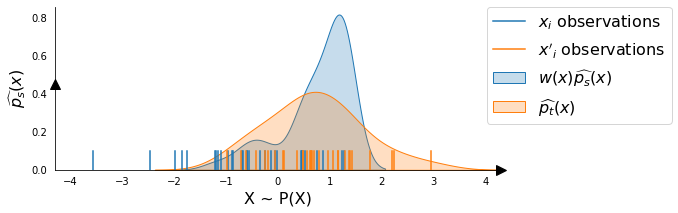

In [13]:
# Plot a kernel density estimation of the densities
show_gaussian(Xs, Xt) 
show_gaussian(Xs, Xt, weights=density_ratio(Xs))

What can be said about the reweighted source density ? 

### Question 1.6

Now that we have computed $w(x)$ we can give a "debiased" estimation of the target risk by reweighting the source risk (cf Equation 1).

Compute a reweighted average of the source errors of the "source only" model and compare it to the target average error.

In [14]:
yps = model_source_only.predict(Xs.reshape(-1, 1))
err_src = np.mean(density_ratio(Xs) * np.square(yps - ys))

ypt = model_source_only.predict(Xt.reshape(-1, 1))
err_tgt = np.mean(np.square(ypt - yt))

print("Source reweighted average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

Source reweighted average squared error : 2.0493
Target average squared error : 2.2630


### Question 1.7

Compute the F statistic 

In [15]:
F = err_src / err_tgt
scipy.stats.f.cdf(F, len(ys)-1, len(yt)-1)

0.39562034032049825

Can we still reject the hypothesis that $\epsilon_s \sim \epsilon_t$ ?

### Question 1.8

We know want to fit the linear regression model based on the reweighted source risk. We want to compute analyticaly the linear regression solution $\beta^*$.

The close-form solution for standard linear regression model is written:

$$\beta^* = (X^T X)^{-1} X^T y$$

For the reweighted linear regression model, the close-form solution becomes:

$$\beta^* = (X^T \Delta X)^{-1} X^T \Delta Y $$

With $\Delta = \text{diag}(w_1, ..., w_m)$, with $w_i = w(x_i)$.

To learn the coeficients $\beta^*$ with scikit-learn, we can use the `sample_weight` argument of the `fit` method:

In [16]:
model_reweighted = LinearRegression()
model_reweighted.fit(Xs, ys, sample_weight=density_ratio(Xs));

We now compare the coeficents of the source only model and the reweighted one:

In [17]:
print("Coeficient of the Source Only Linear Regression Model", [np.float32(model_source_only.intercept_),
                                                                np.float32(model_source_only.coef_[0])])
print("Coeficient of the Reweighted Linear Regression Model", [np.float32(model_reweighted.intercept_),
                                                               np.float32(model_reweighted.coef_[0])])

Coeficient of the Source Only Linear Regression Model [0.62262607, -0.49150756]
Coeficient of the Reweighted Linear Regression Model [0.3857396, 0.5554045]


In [18]:
show(Xs, Xt, ys, yt, model=debiased_model, weights=density_ratio(Xs))

NameError: name 'show' is not defined

In [ ]:
yps = debiased_model(Xs.reshape(-1, 1))
err_src = np.mean(density_ratio(Xs) * np.square(yps - ys))

ypt = debiased_model(Xt.reshape(-1, 1))
err_tgt = np.mean(np.square(ypt - yt))

print("Source reweighted average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

What can be said about the new coeficients

### Question 1.10

Plot the model predictions and compute the new target risk. What do you observe?

In [ ]:
show_gaussian(Xs, Xt, ys, yt, model_reweighted, density_ratio(Xs), show_error_tgt=True)

We now compare the target errors of the source only model and the reweighted model. What do we observe ?

In [ ]:
yps = model_source_only.predict(Xt)
err_tgt_1 = np.mean(np.square(ypt - yt))

ypt = model_reweighted.predict(Xt)
err_tgt_2 = np.mean(np.square(ypt - yt))

print("Target average squared error of the source only model: %.4f"%err_tgt_1)
print("Target average squared error of the reweighted model: %.4f"%err_tgt_2)

When looking at the true target model $P_T(Y|X)$, what can be said about the emprical target error above?

In this case, we compute $w(x)$ anatycally considering that $p_t(x)$ and $p_s(x)$ are known. Do you think this is a realistic assumption ?

In the following, we will see which reweighting approaches can be considered when $p_t(x)$ and $p_s(x)$ are only partially known through empirical samples.

## 2. Instance-based Approaches

In the following, we consider that we have access to both input samples $X_S \sim P_S(X)$ and $X_T \sim P_T(X)$ of respective size $m=n=30$. We also have access to the source label $y_S$ drawn accoring to $P_S(Y|X)$.

### Question 2.1 : PDE

One way to estimate the density ratio $w(x)$ based on empirical source and target input samples $X_S, X_T$ is to perform both density estimations : $\widehat{p_s}(x)$ and $\widehat{p_t}(x)$.

The Paramatric Density-Estimation (PDE) method consists in assuming a prior input distribution with densities $p_s(\theta_s, x)$, $p_t(\theta_t, x)$ for the source and target domains respectively. The parameters $\theta_s$ and $\theta_t$ of the distributions are then estimated through Maximum-Likelihood estimation.

\begin{gather*}
    \widehat{\theta_s^*} = \underset{\theta_s \in \Theta_s}{\text{argmin}} \sum_{x_i \in X_S} \log( p_s(\theta_s, x_i) ) \\
    \widehat{\theta_t^*} = \underset{\theta_t \in \Theta_t}{\text{argmin}} \sum_{x'_i \in X_T} \log( p_t(\theta_t, x'_i) ) \\
    \widehat{w}(x_i) = \frac{p_t(\widehat{\theta_t^*}, x_i)}{p_s(\widehat{\theta_s^*}, x_i)}
\end{gather*}

In our case, we assume a gaussian model and compute the density ratio as follows

In [ ]:
def pde(Xs, Xt):
    mu_src = np.mean(Xs)
    sigma_src = np.std(Xs)

    mu_tgt = np.mean(Xt)
    sigma_tgt = np.std(Xt)

    ps_Xs = gaussian(Xs, mu=mu_src, s=sigma_src) # =  1/(2*np.pi*s**2)**0.5 * np.exp(-(Xs-mu)**2 / (2*s**2))
    pt_Xs = gaussian(Xs, mu=mu_tgt, s=sigma_tgt)
    return  pt_Xs / ps_Xs

weights = pde(Xs, Xt)

We now compare the true density ratio with the estimated one and plot the reweighted density:

In [ ]:
args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xs, Xt, weights=weights)

We can try to modify the number of source and target instances to observe the impact on the estimation of the density ratio:

In [ ]:
np.random.seed(123)
m = 100; n = 100

Xsm = np.random.randn(m, 1) - 1.; Xtn = np.random.randn(n, 1) + 1.;
weights = pde(Xsm, Xtn)

args = np.argsort(Xsm.ravel()).ravel()
plt.plot(Xsm[args], density_ratio(Xsm[args]), label=r"$w(x)$")
plt.plot(Xsm, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xsm, Xtn, weights=weights)

We now modify the input distributions:

In [ ]:
np.random.seed(123)
m = 300; n = 300

Xsm = np.random.exponential(1., (n, 1)) - 1.; Xtn = np.random.exponential(1., (m, 1)) + 1.;
weights = pde(Xsm, Xtn)

args = np.argsort(Xsm.ravel()).ravel()
plt.plot(Xsm[args], density_ratio(Xsm[args]), label=r"$w(x)$")
plt.plot(Xsm, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xsm, Xtn, weights=weights)

What do we observe? Is the gaussian assumption realistic in real scenario ?

### Question 2.2 : KDE (1)

In many cases, the source and target input distributions are not gaussians, to estimate the densities, one can then use a kernel density approach:

Let's consider $k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}_+$ a kernel function. The learner computes estimations of the densities $p_s(x)$, $p_t(x)$ as sums of kernels centered in each observation $x_i \in X_S$ (resp $x'_i \in X_T$).
\begin{gather*}
    \widehat{p_s}(x) = C_s \sum_{x_i \in X_S} k(x, x_i) \\
    \widehat{p_t}(x) = C_t \sum_{x'_i \in X_T} k(x, x'_i) \\
    \widehat{w}(x_i) = \frac{\widehat{p_t}(x_i)}{\widehat{p_s}(x_i)}
\end{gather*}

A typical kernel function is the Gaussian kernel: $k : (x, x') \to \exp\left(-\frac{||x-x'||^2_2}{2 \sigma^2}\right)$. $\sigma \in \mathbb{R_+^*}$ is the kernel bandwidth and can be chosen through Maximum Likelihood estimation.

Compute the Kernel Density Estimation (KDE) with gaussians kernels for the source and target densities, plot the estimated densities and compare the obtained weights to the theoretical one.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

def kde(centers, x, sigma=0.5):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    # dist is a pairwise distance matrix of shape (len(centers), len(x))
    dist = (1./np.sqrt( 2. * np.pi * sigma**2 )) * rbf_kernel(centers, x, gamma=1/(2 * sigma))
    return dist.mean(0) # Average over the centers

def log_likelihood(p):
    return np.mean(np.log(p))

In [ ]:
sigma = 0.5  # kernel bandwidth

x = np.linspace(-4.2, 4.2, 100)
ps_x = kde(Xs, x, sigma=sigma)
pt_x = kde(Xt, x, sigma=sigma)

plt.figure(figsize=(8, 3))
plt.plot(x, ps_x); plt.plot(x, pt_x)
plt.fill_between(x, ps_x, alpha=0.2); plt.fill_between(x, pt_x, alpha=0.2)
plt.show()

In [ ]:
weights = (kde(Xt, Xs, sigma=sigma) /
           kde(Xs, Xs, sigma=sigma))

args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()
show_gaussian(Xs, Xt, weights=weights)

In [ ]:
ll_src = log_likelihood(kde(Xs, Xs, sigma=sigma))

print("Source KDE Log likelihood: %.3f"%ll_src)

### Question 2.3 : KDE (2)

Try different value of kernel bandwidth `sigma`, what do you observe?

In [ ]:
sigma = 1.  # kernel bandwidth

x = np.linspace(-4.2, 4.2, 100)
ps_x = kde(Xs, x, sigma=sigma)
pt_x = kde(Xt, x, sigma=sigma)

plt.figure(figsize=(8, 3))
plt.plot(x, ps_x); plt.plot(x, pt_x)
plt.fill_between(x, ps_x, alpha=0.2); plt.fill_between(x, pt_x, alpha=0.2)
plt.show()

ll_src = log_likelihood(kde(Xs, Xs, sigma=sigma))

print("Source KDE Log likelihood: %.3f"%ll_src)

**(BONUS)** Compute the log likelihood for multiple `sigma` values, in which case the log likelihood is maximized?
Can we use the log likelihood to select a relevant value of `sigma`? What improvement can you propose to find the best `sigma` ?

We can now look at the computational time of KDE in function of $n$ and $m$ the number of target and source instances. Try different values of $n, m$ and observe the impact on the computational time.

In [ ]:
%%time

sigma = 0.5
n = 1000; m = 1000;
Xtn = np.random.randn(n, 1)
Xsm = np.random.randn(m, 1)

weights = (kde(Xtn, Xsm, sigma=sigma) / kde(Xsm, Xsm, sigma=sigma))

What is the complexity of the KDE algorithm ?

In the following, we will look at non parametric density ratio estimation which does not require to estimate both densities $p_s(x)$ and $p_t(x)$.

### Question 2.4 NNW (1)

We now consider the instance-based method "Nearest-Neighbors-Weighting" which derives the source weights based on the pairwise distances between source and target instances:

Let's consider $K \in \mathbb{N}^*$ and define 
$\mathcal{V}_K(x'_j)$ as the set of $K$-Nearest-Neighbors in $X_S$ of $x'_j \in X_T$.

The density ratio $\widehat{w}(x_i)$ is directly estimated through the following heuristic: 
\begin{gather*}
    \widehat{w}(x_i) \propto \text{Card} \left( \left\{ x'_i \in X_T \; | \; x_i \in \mathcal{V}_K(x'_j) \right\} \right)
\end{gather*}


Import the `NearestNeighborsWeighting` object from the [adapt.instance_based](https://adapt-python.github.io/adapt/contents.html#adapt-instance-based) module. 
You can access the documentation [here](https://adapt-python.github.io/adapt/generated/adapt.instance_based.NearestNeighborsWeighting.html). Then fit the weights with the `fit_weights` method and plot the results

Try different value of `n_neighbors` in the range [1, 30], what do you observe? How do you explain the resulting weights for `n_neighbors=30` ? 

In [ ]:
from adapt.instance_based import NearestNeighborsWeighting

nnw = NearestNeighborsWeighting(n_neighbors=5)
weights = nnw.fit_weights(Xs, Xt)
weights /= weights.mean()

In [ ]:
args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xs, Xt, weights=weights)

### Question 2.5 NNW (2)

Every instance-based methods implemented in `adapt` can fit directly an estimator with the learned weights.

Instantiate a `NearestNeighborsWeighting` object with a `LinearRegression` estimator and the target input data `Xt`, then use the `fit` method of the model on `Xs, ys`.

Compute the target error, what do you observe?

In [ ]:
nnw = NearestNeighborsWeighting(estimator=LinearRegression(),
                                n_neighbors=1)

nnw.fit(Xs, ys, Xt=Xt);

In [ ]:
show_gaussian(Xs, Xt, ys, yt, nnw, nnw.weights_/nnw.weights_.mean(), show_error_tgt=True)

Now, look at the computationla time of NNW in function of $n$ and $m$

In [ ]:
%%time

n = 1000; m = 1000;
Xtn = np.random.randn(n, 1)
Xsm = np.random.randn(m, 1)

nnw = NearestNeighborsWeighting(n_neighbors=5)
weights = nnw.fit_weights(Xsm, Xtn)

What is the complexity of the NNW algorithm, is it faster than KDE ? 

### Question 2.6 KMM (1)

We now consider the Kernel Mean matching method (KMM):

The KMM algorithm looks for the density ratio $w(x)$ which minimizes the Maximum Mean Discrepancy (MMD) between the reweighted source distribution $w(x) p_s(x)$ and the target distribution $p_t(x)$:
\begin{equation*}
    w^* = \underset{w}{\text{argmin  }} \text{MMD}\left(p_t(x), w(x) p_s(x)\right)
\end{equation*}

The Maximum Mean Discrepancy is a metric used to compare two distributions by comparing their mean in a RKHS. Applied to the empirical distributions, the optimization problem can be written as follows:

**Optimization**: Using a kernel function $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}_+$, the optimization algorithm solved by KMM is written:

\begin{gather*}
    w^* =\underset{w \in \mathbb{R}^{m \times 1}}{\text{argmin  }} w^T K w  - 2 \kappa^T w \\
    \text{subject to } w \geq 0, w^T \textbf{1} = m
\end{gather*}

Where $K \in \mathbb{R}^{m \times m}$ and $\kappa \in \mathbb{R}^{m \times 1}$ such that: $K_{ij} = k(x_i, x_j)$ and $\kappa_i = \frac{m}{n} \sum_{x'_j \in X_T} k(x_i, x'_j)$ with $x_i, x_j \in X_S$

This formulation is a quadratic programming optimization problem, that can be solved in polynomial time.

Import [`KMM`](https://adapt-python.github.io/adapt/generated/adapt.instance_based.KMM.html#adapt.instance_based.KMM) from [`adapt.instance_based`](https://adapt-python.github.io/adapt/contents.html#adapt-instance-based) and fit the weights. What do you observe? How do you explain that the estimated density ratio $\widehat{w(x)}$ is not continuous with respect to $x$ ?

In [ ]:
from adapt.instance_based import KMM

kmm = KMM()
weights = kmm.fit_weights(Xs, Xt)

In [ ]:
args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xs, Xt, weights=weights)

### Question 2.7

Use the `fit` method to fit a linear model with the learned weights. Compute the target error, what do you observe?

**(BONUS)** How do you explain that KMM and NNW provide lower target risk than the weighted regression using the optimal density ratio ?

In [ ]:
kmm = KMM(estimator=LinearRegression(), verbose=0, random_state=0)
kmm.fit(Xs, ys, Xt=Xt);

In [ ]:
show_gaussian(Xs, Xt, ys, yt, kmm, kmm.weights_, show_error_tgt=True)

## 3. Extensions (BONUS)

Go back to 1. and modify the setting of the exercice, for instance you can try to:
- Use a uniform or exponential distribution as input distributions
- Change the law $p(y|x)$,  by setting, for instance different source and target conditional laws
- Modify the number of data

# Exercice 2 : Rare Event Probability Estimation

In this exercice, we consider the task of probability estimation of rare event. We consider the scenario where we have access to a simulator that can provide the label $y \in \mathbb{R}$ for a specific design $x \in \mathbb{R}^2$, composed of two design variable $X_1$ and $X_2$. The goal is to estimate the probability that $y$ is above a threshold $\tau$. We assume that computing labels with the simulator is expensive, and we aim at minimizing the number of simulations require to estimate $P(y > \tau)$.

For this purpose, we use **importance sampling** to focus the simulations on design space regions where $y$ is high. This process provides a biased sample which we will correct with **importance weighting** methods developed in Adapt.

In this experiment, we consider the Rosenbrock function, defined for every $x = (x_0, x_1) \in \mathbb{R}^2$ as:

\begin{equation*}
    f((x_0, x_1)) = (1-x_0)^2 + 100 * (x_1 - x_0^2)^2
\end{equation*}

We consider three different input distributions for the variable $X \in \mathbb{R}^2$ :
- **Uniform**: $X \sim \mathcal{U}([-1.5, 1.5] \times [-0.5, 2.5])$
- **Truncated Uniform**: $X \sim \mathcal{U}([-1.5, 1.5] \times [-0.5, 2.5])$ sc $(x_0 - 1)^3-x_1+1 \leq 0, x_0 + x_1-2 \leq 0$ for any $x=(x_0, x_1) \sim X$.
- **Gaussian**: $X \sim \mathcal{N}([0, 1], 0.5 \text{Id}_2)$

We consier a threshold $\tau = 670$

In [ ]:
from utils import sample_uniform, sample_gaussian, sample_truncated, rosenbrock, show_rare_event

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, sample_func in zip(axes.ravel(), [sample_uniform, sample_gaussian, sample_truncated]):
    np.random.seed(0)
    X_full = sample_func(10000); y_full = rosenbrock(X_full)
    show_rare_event(X_full, y_full, ax=ax, title=sample_func.__name__)
plt.subplots_adjust(wspace=0.4)
plt.show()

We can see that the probability that $y = f(X) > 670$ is rather small (around $10^{-3}) which makes it difficult to estimate with small Monte-Carlo samples.

Notice that, here, to provide a "ground-truth" probability $P(y > 670)$ we sample 10k data points in the design space (matrix `X_full`) and compute the corresponding outputs `y_full`. In practice, only `X_full` is available because computing the outputs for 10k is too expensive.

### Question 1 : Monte-Carlo Estimation

We now consider the Monte-Carlo estimation of the probability $P(y > 670)$ with sample of size $100$. (Monte-Carlo samples are represented with white dots)

In [ ]:
n_montecarlo = 100

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, sample_func in zip(axes.ravel(), [sample_uniform, sample_gaussian, sample_truncated]):
    np.random.seed(0)
    X_full = sample_func(10000); y_full = rosenbrock(X_full);
    X_mc = sample_func(n_montecarlo); y_mc = rosenbrock(X_mc);
    show_rare_event(X_full, y_full, X_mc, y_mc, ax=ax, title=sample_func.__name__)
plt.subplots_adjust(wspace=0.4)
plt.show()

What can be said about the estimated probability ? How this estimation changes with the number of Monte-Carlo estimation ?

### Question 2 : Importance Sampling

To get some positive label ($y > 670$) we consider an iterative sampling algorithm based on importance sampling computed through surrogate model. At each iteration of the algorithm, a sample of size $n=100$ is draw in the design space, then the sample is reweighted using the predictions $\hat{y}$ of a surrogate model by giving more importance to data points for which $\hat{y}$ is high. Finally, some data points are selected among the $100$ data according to their importance. We then get the true labels $y$ for these $k=10$ data points (through simulation) and use these labels to update the surrogate model. These steps are repeated until we get $n=100$ labels.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

def importance_sampling(sample, model, n=100, k=10, power=10, verbose=0):
    sample_x = sample(k)
    sample_y = model(sample_x)
    max_y = np.max(sample_y)
    min_y = np.min(sample_y)
    while len(sample_x) < n:
        surrogate_model = DecisionTreeRegressor()
        surrogate_model.fit(sample_x, sample_y)
        
        candidates_x = sample(n)
        uniform = np.random.uniform(0, 1, n)

        candidates_y = surrogate_model.predict(candidates_x)
        
        importance = (candidates_y - min_y) / (max_y - min_y)
        
        mask = importance**power >= uniform

        candidates_x = candidates_x[mask][:k]
        
        if verbose:
            print(len(candidates_x))
        
        if len(candidates_x) > 0:
            candidates_y = model(candidates_x)
        
            sample_x = np.concatenate((sample_x, candidates_x))
            sample_y = np.concatenate((sample_y, candidates_y))
            max_y = np.max(sample_y)
            min_y = np.min(sample_y)
        
    return sample_x, sample_y

In [ ]:
n_montecarlo = 100

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, sample_func in zip(axes.ravel(), [sample_uniform, sample_gaussian, sample_truncated]):
    np.random.seed(0)
    X_full = sample_func(10000); y_full = rosenbrock(X_full);
    X_mc, y_mc = importance_sampling(sample_func, rosenbrock, n=n_montecarlo, k=10, power=5);
    show_rare_event(X_full, y_full, X_mc, y_mc, ax=ax, title=sample_func.__name__)
plt.subplots_adjust(wspace=0.4)
plt.show()

What can be said about the estimated probability ?

**(BONUS)** Modify the parameter `power` of the importance sampling function. What is the impact of this parameter?

### Question 3

We now have positive labels for which $y > 670$, but because of the importance sampling process, the monte-carlo sample is biased and cannot be use directly to estimate $P(y > 670)$.

If we consider our importance sampled monte-carlo sample `X_mc, y_mc` as a source labeled sample of size $n=100$ and our full input sample `X_full` as a target sample of size $m = 10000$. We have a sample bias problem that can be solved with instance-based transfer learning methods. Our goal is indeed to reweight `X_mc, y_mc` in order to provide a debiased estimation of the probbaility.

We then consider the [KLIEP](https://adapt-python.github.io/adapt/generated/adapt.instance_based.KLIEP.html) algorithm implemented in Adapt. This algorithm follows a similar paradigm than KMM, but consider the Kullback-Leibler divergence instead of the MMD:

The KLIEP algorithm looks for the density ratio $w(x)$ which minimizes the Kullback-Leibler divergence between the reweighted source distribution $w(x) p_s(x)$ and the target distribution $p_t(x)$:
\begin{equation*}
    w^* = \underset{w}{\text{argmin}} \text{KL}\left(p_t(x), w(x) p_s(x)\right)
\end{equation*}

**Optimization**: Writing $w$ as a linear combination of kernel function $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}_+$: $w(x) = \sum_{j=1}^b \alpha_j k(x, x'_j)$, the optimization algorithm solved by KLIEP is written:
\begin{gather*}
   \alpha^* = \underset{\alpha \in \mathbb{R}^b}{\text{argmin}} \sum_{x'_i \in X_T} \log \left(\sum_{j=1}^b \alpha_j k(x'_i, x'_j) \right) \\
   \text{sc} \sum_{x_i \in X_S} \sum_{j=1}^b \alpha_j k(x_i, x'_j) = 1 \; \text{and} \; \alpha \geq 0
\end{gather*}

Which is a convex optimization problem under linear constraints that can be solved with projected gradient algorithms for instance.

**Important Note**: Another difference with KMM is that KLIEP uses a kernel parametrization for the source weights, based on $b$ kernel centers chosen in $X_T$. This avoid computing the pairwise kernel between for each source and target pairs, which is helpfull when the number of target instances is large as in our example ($m=10000$).

In [ ]:
from adapt.instance_based import KLIEP

kliep = KLIEP(max_centers=100, verbose=2, max_iter=500, gamma=10., random_state=0)

In [ ]:
n_montecarlo = 100

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, sample_func in zip(axes.ravel(), [sample_uniform, sample_gaussian, sample_truncated]):
    np.random.seed(0)
    X_full = sample_func(10000); y_full = rosenbrock(X_full);
    X_mc, y_mc = importance_sampling(sample_func, rosenbrock, n=n_montecarlo, k=10, power=5);

    weights = kliep.fit_weights(X_mc, X_full)
    weights /= weights.mean()

    show_rare_event(X_full, y_full, X_mc, y_mc, weights=weights, ax=ax, title=sample_func.__name__)
plt.show()

What do you observe ?

Try different values for the kernel bandwidth parameter `gamma` and different values of `max_center`, what is the impact of these parameters ?

# Exercise 3 : CT-Scan Dataset

We now consider a real-life transfer scenario using the [CT-Scan dataset](https://archive.ics.uci.edu/ml/datasets/Relative+location+of+CT+slices+on+axial+axis) from the UCI machine leanring repository.

This dataset is composed of more than $50000$ Ct-Scan slices coming from around $100$ different patients. The goal is to predict the relative location of the slice in the patient based on features extracted from the slice (cf Figure below)

![ctscan](ctscan.png)

We consider the following transfer learning scenario, where the learner has access to labeled data for every patients except one:  discard the patient with the more data and consider it as a target patient. We are in the realistic situation where an expert (radiologist) has labeled the data for many patients, but the model is applied on new coming patient for which no labels is available.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00206/slice_localization_data.zip")

print(df.shape)
df.head()

In [ ]:
X = df.drop(["patientId", "reference"], axis=1)
y = df["reference"]

In [ ]:
source_ids = [i for i in range(97) if i != 46]
target_ids = [46]

X_src = X.loc[df.patientId.isin(source_ids)]
X_tgt = X.loc[df.patientId.isin(target_ids)]

y_src = y.loc[df.patientId.isin(source_ids)]
y_tgt = y.loc[df.patientId.isin(target_ids)]

In [ ]:
print("Shape of Xs", X_src.shape)
print("Shape of Xt", X_tgt.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_src, y_src, train_size=0.8)

### Question 1

The plots below show the two first components of the PCA of the 384 input features. We compare the difference between the train and test set which are uniform splits of the source dataset and the difference between the source and target dataset.

What do we observe? Can we consider this problem as a transfer learning problem?

In [ ]:
from sklearn.decomposition import PCA

X_pca = PCA(2).fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(X_pca[X_train.index, 0], X_pca[X_train.index, 1], 'o', label="Train", markeredgecolor="w", ms=5)
ax1.plot(X_pca[X_test.index, 0], X_pca[X_test.index, 1], 'o', label="Test", markeredgecolor="w", ms=5)

ax2.plot(X_pca[X_src.index, 0], X_pca[X_src.index, 1], 'o', label="Source", markeredgecolor="w", ms=5)
ax2.plot(X_pca[X_tgt.index, 0], X_pca[X_tgt.index, 1], 'o', label="Target", markeredgecolor="w", ms=5, c="red")

ax1.legend(); ax2.legend()
ax1.set_title("PCA Train-Test"); ax2.set_title("PCA Source-Target")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.hist(y_train, density=True, bins=30, label="Train")
ax1.hist(y_test, alpha=0.5, density=True, bins=30, label="Test")

ax2.hist(y_src, label="Source", density=True, bins=30)
ax2.hist(y_tgt, label="Target", density=True, bins=30, alpha=0.5, color="red")

ax1.legend(); ax2.legend()
ax1.set_title("Output Distribution Train-Test"); ax2.set_title("Output Distribution Source-Target")

plt.show()

### Question 2

Fir a `Ridge` regression model on the training data and compute the source risk (on the test set) and the target risk.

What can be observed?

In [ ]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train);

In [ ]:
yps = model.predict(X_test)
err_src = np.mean(np.square(yps - y_test))
ypt = model.predict(X_tgt)
err_tgt = np.mean(np.square(ypt - y_tgt))

print("Source average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

plt.figure(figsize=(6, 6))
plt.plot(y_test, yps, 'o', label="Source - MSE : %.3f"%err_src, markeredgecolor="w", ms=5)
plt.plot(y_tgt, ypt, 'o', label="Target - MSE : %.3f"%err_tgt, markeredgecolor="w", ms=5, c="red")
plt.plot([np.min(y_src), np.max(y_src)], [np.min(y_src), np.max(y_src)], c="k", alpha=0.5)
plt.ylabel(r"$\widehat{Y}$", fontsize=14); plt.xlabel(r"Y", fontsize=14); plt.legend(fontsize=14); plt.show()

### Question 3

Can we consider that the source risk is a good estimation of the target risk? is the covariate-shift assumption realistic in this case?

### Question 4 : KDE

We know try to apply KDE to the problem.

Try to compute an estimation of $p_s(x)$ with different source sample sizes. Compute the computational time for each size. What is the complexity of the algorithm?

In [ ]:
import time

n = 100
t0 = time.time()
X_s = X_src.sample(n)
ps_xs = kde(X_s, X_s)
t1 = time.time()
print("Time %.3f"%(t1-t0))

In [ ]:
times = []
n_samples = [100, 500, 1000, 2000, 5000, 10000]

t0 = time.time()

for n in n_samples:
    X_s = X_src.sample(n)
    ps_xs = kde(X_s, X_s)
    t1 = time.time()
    times.append(t1-t0)
    t0 = t1

In [ ]:
plt.plot(n_samples, times, "o", label="Computational Times")
plt.plot(np.arange(0, n_samples[-1]), times[-1] * np.arange(0, n_samples[-1])**2 / n_samples[-1]**2,
         label=r"$t = n^2$")
plt.legend(); plt.show()

### Question 5 : NNW (1)

What is the complexity of the NNW algorithm, is it more adapted than KDE to our problem?

Fit a reweighted Ridge regression using the weights from NNW. Plot the weights on the PCA. What do you observe?

In [ ]:
from adapt.instance_based import NearestNeighborsWeighting

nnw = NearestNeighborsWeighting(estimator=Ridge(), Xt=X_tgt, n_neighbors=5)

nnw.fit(X_train, y_train);

In [ ]:
yps = nnw.predict(X_test)
err_src = np.mean(np.square(yps - y_test))
ypt = nnw.predict(X_tgt)
err_tgt = np.mean(np.square(ypt - y_tgt))

print("Source average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

plt.figure(figsize=(6, 6))
plt.plot(y_test, yps, 'o', label="Source - MSE : %.3f"%err_src, markeredgecolor="w", ms=5)
plt.plot(y_tgt, ypt, 'o', label="Target - MSE : %.3f"%err_tgt, markeredgecolor="w", ms=5, c="red")
plt.plot([np.min(y_src), np.max(y_src)], [np.min(y_src), np.max(y_src)], c="k", alpha=0.5)
plt.ylabel(r"$\widehat{Y}$", fontsize=14); plt.xlabel(r"Y", fontsize=14); plt.legend(fontsize=14); plt.show()

In [ ]:
weights = nnw.weights_
weights /= weights.mean()

X_pca = PCA(2).fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(X_pca[X_train.index, 0], X_pca[X_train.index, 1], label="Source", edgecolor="w", s=5 * weights)
ax.plot(X_pca[X_tgt.index, 0], X_pca[X_tgt.index, 1], 'o', label="Target", markeredgecolor="w", ms=5, c="red")

ax1.legend(); ax2.legend()
ax1.set_title("PCA Train-Test"); ax2.set_title("PCA Source-Target")
plt.show()

### Question 6 : NNW (2)

Try different vlaues of `n_neighbors`. What is the best value?

**(BONUS)** Propose some ideas to select the best value `n_neighbors`

### Question 7 : KLIEP (1)

Try the same thing with KLIEP. Use different values of the `gamma` argument, what do you observe?

In [ ]:
from adapt.instance_based import KLIEP

kliep = KLIEP(estimator=Ridge(), Xt=X_tgt, gamma=1.)

kliep.fit(X_train, y_train);

In [ ]:
yps = kliep.predict(X_test)
err_src = np.mean(np.square(yps - y_test))
ypt = kliep.predict(X_tgt)
err_tgt = np.mean(np.square(ypt - y_tgt))

print("Source average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

plt.figure(figsize=(6, 6))
plt.plot(y_test, yps, 'o', label="Source - MSE : %.3f"%err_src, markeredgecolor="w", ms=5)
plt.plot(y_tgt, ypt, 'o', label="Target - MSE : %.3f"%err_tgt, markeredgecolor="w", ms=5, c="red")
plt.plot([np.min(y_src), np.max(y_src)], [np.min(y_src), np.max(y_src)], c="k", alpha=0.5)
plt.ylabel(r"$\widehat{Y}$", fontsize=14); plt.xlabel(r"Y", fontsize=14); plt.legend(fontsize=14); plt.show()

In [ ]:
weights = kliep.weights_
weights /= weights.mean()

X_pca = PCA(2).fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(X_pca[X_train.index, 0], X_pca[X_train.index, 1], label="Source", edgecolor="w", s=5 * weights)
ax.plot(X_pca[X_tgt.index, 0], X_pca[X_tgt.index, 1], 'o', label="Target", markeredgecolor="w", ms=5, c="red")

ax1.legend(); ax2.legend()
ax1.set_title("PCA Train-Test"); ax2.set_title("PCA Source-Target")
plt.show()

### Question 8 : KLIEP (2)

Put a list of possible values for gamma, explain what is happening?

In [ ]:
kliep = KLIEP(estimator=Ridge(), Xt=X_tgt, gamma=[0.1, 0.5, 1., 2.], max_centers=100, max_iter=500)

kliep.fit(X_train, y_train);

In [ ]:
yps = kliep.predict(X_test)
err_src = np.mean(np.square(yps - y_test))
ypt = kliep.predict(X_tgt)
err_tgt = np.mean(np.square(ypt - y_tgt))

print("Source average squared error : %.4f"%err_src)
print("Target average squared error : %.4f"%err_tgt)

plt.figure(figsize=(6, 6))
plt.plot(y_test, yps, 'o', label="Source - MSE : %.3f"%err_src, markeredgecolor="w", ms=5)
plt.plot(y_tgt, ypt, 'o', label="Target - MSE : %.3f"%err_tgt, markeredgecolor="w", ms=5, c="red")
plt.plot([np.min(y_src), np.max(y_src)], [np.min(y_src), np.max(y_src)], c="k", alpha=0.5)
plt.ylabel(r"$\widehat{Y}$", fontsize=14); plt.xlabel(r"Y", fontsize=14); plt.legend(fontsize=14); plt.show()

In [ ]:
weights = kliep.weights_
weights /= weights.mean()

X_pca = PCA(2).fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(X_pca[X_train.index, 0], X_pca[X_train.index, 1], label="Source", edgecolor="w", s=5 * weights)
ax.plot(X_pca[X_tgt.index, 0], X_pca[X_tgt.index, 1], 'o', label="Target", markeredgecolor="w", ms=5, c="red")

ax1.legend(); ax2.legend()
ax1.set_title("PCA Train-Test"); ax2.set_title("PCA Source-Target")
plt.show()

### Question 9 (Extension)

Tru the same exercice with others regressor as DecisionTree and RandoForest, what do you observe ? 